In [3]:
import sys
sys.path.insert(0, "../")

In [4]:
import numpy as np
import netket as nk
from netket.operator.spin import sigmax, sigmaz
import jax



In [5]:
from spinlattice.lattice import get_lattice_data, LatticeData
from spinlattice.models.dimer import DimerHexagonal

%load_ext autoreload
%autoreload 2


In [6]:
lattice = get_lattice_data(
    "dimer-hexagonal-lattice",
    "dimer-hexagonal",
    [
        2,
        2,
    ],
    "periodic",
)
dimer = DimerHexagonal(lattice)

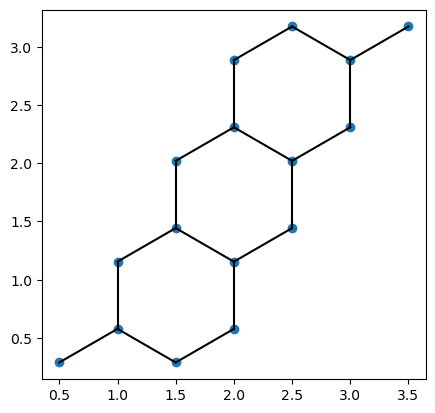

In [7]:
g=nk.graph.Honeycomb(extent=[2, 4], pbc=False)
pos = g.positions
edges = g.edges()

# Plot posistions of nodes  and edges
import matplotlib.pyplot as plt
plt.scatter(pos[:, 0], pos[:, 1])
for edge in edges:
    x_coords = [pos[edge[0], 0], pos[edge[1], 0]]
    y_coords = [pos[edge[0], 1], pos[edge[1], 1]]
    plt.plot(x_coords, y_coords, 'k-')
#set the same scale for x and y
plt.gca().set_aspect('equal')
plt.show()



In [126]:
H = dimer.hamiltonian(1.0, 1.0)
# H = dimer.dimer_flip(1.0)
H._setup()
x = np.ones(H.hilbert.size)
# np.isnan( H._mels ).sum(axis=(1, 2))

In [157]:
H.hilbert.size

16

In [136]:
import time

ma = nk.models.RBM(alpha=1, use_hidden_bias=False, use_visible_bias=False)
H = dimer.effective_hamiltonian(1.0, 1.0, 1)
# H = H.to_jax_operator()
# Build the sampler
sa = nk.sampler.MetropolisHamiltonian(hilbert=dimer.hi, hamiltonian=H)
# sa = nk.sampler.MetropolisLocal(hilbert=dimer.hi)
# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=H,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

/Users/keisuke/miniconda3/envs/py310/lib/python3.10/site-packages/netket/vqs/mc/mc_state/state.py:257: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples
100%|██████████| 600/600 [00:11<00:00, 50.89it/s, Energy=-6.032 ± 0.028 [σ²=0.781, R̂=1.0058]]

### RBM calculation
Has 256 parameters
The RBM calculation took 11.823448181152344 seconds


In [137]:
# uniform = jax.numpy.zeros_like(vs.parameters["Dense"]["kernel"])
# # uniform /= jax.numpy.linalg.norm(uniform)
# vs.parameters = {"Dense": {"kernel": uniform}}



# gs = nk.VMC(
#     hamiltonian=H,
#     optimizer=op,
#     preconditioner=sr,
#     variational_state=vs)

# start = time.time()
# gs.run(out='RBM', n_iter=600)
# end = time.time()

# print('### RBM calculation')
# print('Has',vs.n_parameters,'parameters')
# print('The RBM calculation took',end-start,'seconds')

In [139]:
import scipy.sparse as sp
H_sparse = H.to_sparse()
E, V = sp.linalg.eigsh(H_sparse, k=6, which='SA')

In [148]:
V[:, 0]

array([-4.82101062e-02,  2.64480276e-14,  8.33648070e-14, ...,
        8.33656773e-14,  2.63996632e-14, -4.82101062e-02])

In [146]:
np.all(np.sign(np.round(V[:, 0], 5)) <= 0)

True

In [110]:
states = H.hilbert.all_states()
log_probs = ma.apply({"params":vs.parameters}, states)
log_probs -= np.mean(log_probs)
phi = np.exp(log_probs)
phi /= np.linalg.norm(phi)

In [111]:
phi @ H_sparse @ phi

2.3824978799951824

In [7]:
import scipy.sparse as sp
H_sparse = H.to_sparse()
E, V = sp.linalg.eigsh(H_sparse, k=6, which='SA')




In [98]:
H_sparse.toarray() @ np.

array([[ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 66., -1., ...,  0.,  0.,  0.],
       [ 0., -1., 22., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 22., -1.,  0.],
       [ 0.,  0.,  0., ..., -1., 66.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  4.]])

In [120]:
H = dimer.hamiltonian(1.0, 1.0)

In [121]:
dimer.constraint()

LocalOperator(dim=16, #acting_on=24 locations, constant=32.0, dtype=float64)